In [1]:
from dotenv import load_dotenv
import os
import torch
from typing import Optional
from transformers import AutoModelForCausalLM, AutoTokenizer
from localise_units import ImportLLMfromHF, LayersUnits, LocImportantUnits
from dataset import ToMLocDataset
from benchmark import BenchmarkToMi
from assess import AssessBenchmark
load_dotenv()
hf_access_token = os.getenv("HF_ACCESS_TOKEN")
cache_dir = os.getenv("CACHE_DIR")
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model and tokenizer onto GPU
checkpoint = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token)
model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

(131072,)


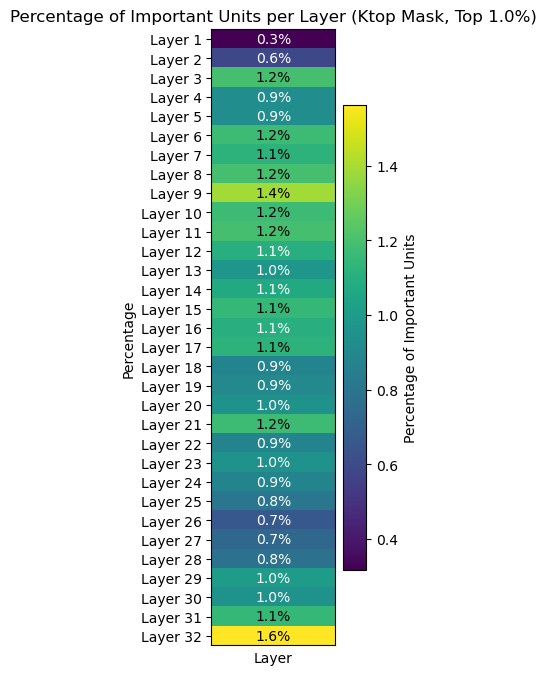

In [2]:
tom_data = ToMLocDataset()
llm = ImportLLMfromHF(model, tokenizer)
units = LayersUnits(llm, tom_data)
loc_units = LocImportantUnits(checkpoint, units.data_activation)
loc_units.plot_layer_percentages(0.01)

In [3]:
bn_tomi = BenchmarkToMi()
bn_assess = AssessBenchmark(llm, loc_units, batch_size=20)
res = bn_assess.experiment(bn_tomi)

100%|██████████| 62/62 [01:13<00:00,  1.18s/it]


Diff saved to diff.json


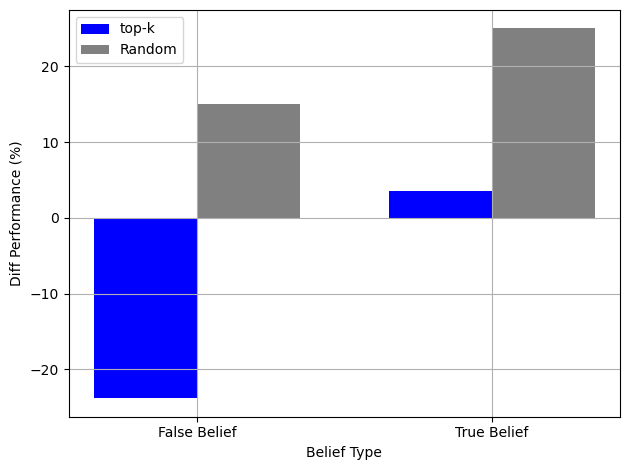

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json

def compute_diff(df, is_random=False):
    """
    Computes the difference in performance between ablation and no ablation
    for False Belief and True Belief categories.

    Args:
        df (pd.DataFrame): Data frame containing the necessary columns.
        is_random (bool): Flag to include random computations.

    Returns:
        dict: Dictionary containing differences for "False Belief" and "True Belief."
    """
    falsebelief_df = df[df["falseTrueBelief"] == False]
    truebelief_df = df[df["falseTrueBelief"] == True]

    # Compute differences for top_k
    diff_false_top = (falsebelief_df["answer"] == falsebelief_df["predict_ablate_top_1"]).mean() - (
            falsebelief_df["answer"] == falsebelief_df["predict_no_ablation"]).mean()
    diff_true_top = (truebelief_df["answer"] == truebelief_df["predict_ablate_top_1"]).mean() - (
            truebelief_df["answer"] == truebelief_df["predict_no_ablation"]).mean()

    # Initialize result
    diff = {
        "False Belief": {"top_k": [diff_false_top]},
        "True Belief": {"top_k": [diff_true_top]}
    }

    # Include random if required
    if is_random:
        diff["False Belief"]["random"] = [0.15]
        diff["True Belief"]["random"] = [0.25]

    return diff

def barplot_diff(input_data, is_random=False, input_type="dataframe"):
    """
    Plots a bar plot comparing False Belief and True Belief differences.

    Args:
        input_data: Either a pandas DataFrame or a JSON file path containing the data.
        is_random (bool): Flag indicating if random values are included (only for DataFrame input).
        input_type (str): Type of input, either "dataframe" or "json".

    Returns:
        None
    """
    # Determine the source of data
    if input_type == "dataframe":
        # Compute differences from the DataFrame
        diff = compute_diff(input_data, is_random)
    elif input_type == "json":
        # Load differences from the JSON file
        with open(input_data, "r") as json_file:
            diff = json.load(json_file)
    else:
        raise ValueError("Invalid input_type. Must be 'dataframe' or 'json'.")

    # Extracting top-k values for False Belief and True Belief
    fbelief_topk = [fb_val * 100 for fb_val in diff["False Belief"]["top_k"]]
    tbelief_topk = [tb_val * 100 for tb_val in diff["True Belief"]["top_k"]]

    # Check if random values are included
    is_random = "random" in diff["False Belief"]
    if is_random:
        fbelief_random = [fb_val * 100 for fb_val in diff["False Belief"]["random"]]
        tbelief_random = [tb_val * 100 for tb_val in diff["True Belief"]["random"]]

    # Set up categories and bar positions
    categories = ["False Belief", "True Belief"]
    x = np.arange(len(categories))
    width = 0.35

    # Plotting
    fig, ax = plt.subplots()

    if is_random:
        # Plot top-k and random bars side by side
        bars1 = ax.bar(x - width / 2, [fbelief_topk[0], tbelief_topk[0]], width, label="top-k", color="blue")
        bars2 = ax.bar(x + width / 2, [fbelief_random[0], tbelief_random[0]], width, label="Random", color="grey")
    else:
        # Center the bars when only top-k is plotted
        bars1 = ax.bar(x, [fbelief_topk[0], tbelief_topk[0]], width, label="top-k", color="blue")

    # Add labels, title, and legend
    ax.set_xlabel('Belief Type')
    ax.set_ylabel('Diff Performance (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)

    # Add legend dynamically based on what is plotted
    if is_random:
        ax.legend()
    else:
        ax.legend(["top-k"])

    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def save_diff(df, is_random=False, file_path="diff.json"):
    """
    Saves the computed differences in a JSON file.

    Args:
        df (pd.DataFrame): Data frame containing the necessary data.
        is_random (bool): Flag indicating if random values are included.
        file_path (str): Path to save the JSON file.

    Returns:
        None
    """
    # Compute differences
    diff = compute_diff(df, is_random)

    # Save to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(diff, json_file, indent=4)
    print(f"Diff saved to {file_path}")


save_diff(res, True)
barplot_diff("diff.json", input_type="json")